In [1]:
import numpy as np
from pybasicbayes.distributions import Gaussian
from src.hmm_base_class import _HMM
from src.hmm_coord_descent import VB_HMM
import matplotlib.pyplot as plt

/Users/askates/anaconda3/envs/python3.5/lib/python3.5/site-packages/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/askates/anaconda3/envs/python3.5/lib/python3.5/site-packages/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


In [43]:
N = 10000
D = 2
K = 3

class HMM:
    def __init__(self):
        pass

    def simulate(self,nSteps):
        def drawFromMultinomial(t):
            return np.where(np.random.multinomial(1,t) == 1)[0][0]

        states = np.zeros(nSteps, dtype=np.int)

        # Initial values. For sake of simplicity, there is only one initial prob vector
        states[0] = drawFromMultinomial(self.pi)

        for i in range(1,nSteps):
            states[i] = drawFromMultinomial(self.t[states[i-1],:])
        return states

hmm = HMM()
hmm.pi = np.array([0.3, 0.3, 0.4])
hmm.t = np.array([
    [0.97, 0.03, 0.0],
    [0.00, 0.97, 0.03],
    [0.03, 0.0, 0.97]])
state_seq = hmm.simulate(N)

mu = np.array([[-30., -30.],[-15., 12],[10., 7]])
distributions = []
for i in range(K):
    distributions.append(np.random.multivariate_normal(mu[i], np.eye(D), N).T)

data = np.zeros([N, D])
for n, s in enumerate(state_seq):
    data[n]  = distributions[s][:, n]

In [44]:
mu_0 = np.zeros(D)
sigma_0 = np.eye(D)
kappa_0 = 0.01
nu_0 = D + 2

prior_emit = [Gaussian(mu_0=mu_0, sigma_0=sigma_0, kappa_0=kappa_0, 
                       nu_0=nu_0) for _ in range(K)]
var_emit = [Gaussian(mu_0=mu_0, sigma_0=sigma_0, kappa_0=kappa_0, 
                     nu_0=nu_0, mu=np.random.randn(D), sigma=np.eye(D)) 
            for _ in range(K)]

prior_emit = np.array(prior_emit)
prior_tran = np.ones(K*K).reshape((K,K))
prior_init = np.ones(K)

hmm = VB_HMM(data, prior_init, prior_tran, prior_emit)
hmm._var_emit = var_emit

/Users/askates/anaconda3/envs/python3.5/lib/python3.5/site-packages/pybasicbayes/util/stats.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


In [45]:
converged, lb = hmm.infer()

Iteration 0
Iteration 1
Iteration 2
Iteration 3


In [48]:
def plot_emissions(data, var_prior, var_emissions):
    plt.figure()
    plt.scatter(data[:,0], data[:,1])
    for G in var_prior:
        plt.scatter(*G.mu, color='green')
    for G in var_emissions:
        plt.scatter(*G.mu, color='red')

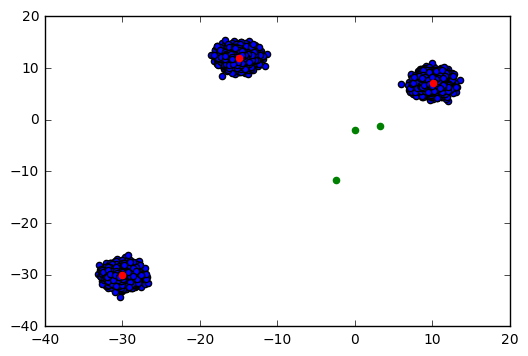

In [49]:
plot_emissions(hmm._obs, hmm._emit_0, hmm._var_emit)
plt.show()

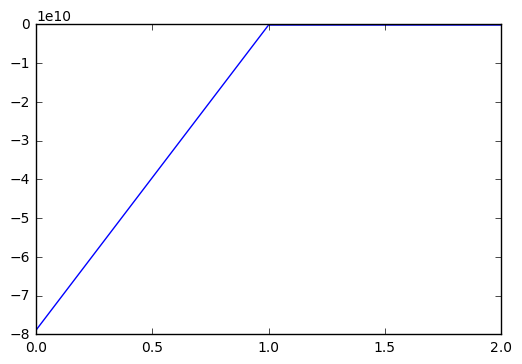

In [47]:
plt.plot(lb)
plt.show()